In [1]:
import numpy as np
import pandas as pd 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
os.path.join(PROJECT_ROOT_DIR)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
CLEAREDDATA_PATH = os.path.join(PROJECT_ROOT_DIR, "cleareddata")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(CLEAREDDATA_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from pipe_classes import *

./data/nyc_benchmarking_disclosure_2017_consumption_data.xlsx
./data/scotch_review.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_excel(PROJECT_ROOT_DIR+'/data/nyc_benchmarking_disclosure_2017_consumption_data.xlsx','Information and Metrics')

In [3]:
data = data.replace({'Not Available': np.nan})

In [4]:
data.select_dtypes(exclude=['number']).keys()

Index(['Property Name', 'Parent Property Id', 'Parent Property Name',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2 (self-reported)', 'Postal Code', 'Street Number',
       'Street Name', 'Borough', 'DOF Gross Floor Area (ft²)',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type', '2nd Largest Property Use Type',
       '3rd Largest Property Use Type', 'Metered Areas (Energy)',
       'Metered Areas  (Water)', 'Annual Maximum Demand (MM/YYYY)',
       'Water Required?', 'Generation Date',
       'DOF Benchmarking Submission Status'],
      dtype='object')

In [5]:
data.select_dtypes('number').keys().size

37

### First exercise: Random Forrest without PCA or collinear features remover and without the sqrt-log feature adder

In [6]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

reg_target="ENERGY STAR Score"
spec_cols=['Water Use (All Water Sources) (kgal)','Largest Property Use Type - Gross Floor Area (ft²)','index','Order','Property Id']

prep_pipeline = Pipeline([
        ('deleter', MissVals_Deleter()),
        ('outremover', Outliers_Remover(['Site EUI (kBtu/ft²)'])),
        ('feature_encoder', Feature_Encoder(reg_target,['Borough', 'Largest Property Use Type'])),
        ('speccolumn_remover', SpecColumn_Remover(spec_cols)),
        ('strattraintest_splitter', StratTrainTest_Splitter(reg_target, [0., 20., 45., 70., 90., np.inf], [1, 2, 3, 4, 5], verbose = True)),
    ])

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

X, X_test, y, y_test = prep_pipeline.fit_transform(data)

Your selected dataframe has 60 columns.
There are 43 columns that have missing values.
By the remove percentage criterion 50, we may remove 19 columns.
(0, 96)
(24724, 96)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


               Overall  Stratified    Random  Rand. %error  Strat. %error
(0.0, 20.0]   0.196449    0.196414  0.195201     -0.635245      -0.017647
(20.0, 45.0]  0.197177    0.197223  0.199110      0.980561       0.023400
(45.0, 70.0]  0.223184    0.223106  0.220005     -1.424188      -0.034945
(70.0, 90.0]  0.198269    0.198301  0.199110      0.424365       0.016412
(90.0, inf]   0.184922    0.184956  0.186573      0.893172       0.018375


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
X = num_pipeline.fit_transform(X)
X_test = num_pipeline.fit_transform(X_test)
X.shape

(17306, 95)

In [8]:
def results_display(reg, X, X_test, y, y_test):
    from sklearn.metrics import mean_squared_error, r2_score
    from timeit import default_timer as timer
    start = timer()
    reg.fit(X, y)
    #train set
    X_pred = reg.predict(X)
    X_rmse = np.sqrt(mean_squared_error(y, X_pred))
    X_R2 = r2_score(y, X_pred)
    #test set
    X_test_pred = reg.predict(X_test)
    X_test_rmse = np.sqrt(mean_squared_error(y_test, X_test_pred))
    X_test_R2 = r2_score(y_test, X_test_pred)
    end = timer()
    print(str(reg))
    print('Train set: Regressor name, RMSE, R2')
    print(reg.__class__.__name__, round(X_rmse,3), round(X_R2,3))
    print('Test set: Regressor name, RMSE, R2')
    print(reg.__class__.__name__, round(X_test_rmse,3), round(X_test_R2,3))
    print('Time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------')

In [9]:
from sklearn.ensemble import RandomForestRegressor
base_reg=RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)

from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from timeit import default_timer as timer

def full_RFRAnalyzer(X, X_test, y, y_test):
    start = timer()

    param_grid = [
        # try 2 (2) combinations of hyperparameters
        {'n_estimators': [200, 250]},
        ]

    rf_reg = RandomForestRegressor(criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=200, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)

    # train across 5 folds, that's a total of 2*5=10 rounds of training 
    grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(X, y)
    end = timer()
    grid_best_est=grid_search.best_estimator_
    print('Best estimator: '+str(grid_best_est))
    print('Best params: %s'%grid_search.best_params_)
    print('---------------------------------------------------------------------')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

    print('---------------------------------------------------------------------')
    results_display(grid_best_est, X, X_test, y, y_test)
    print('Full time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------------------')

In [11]:
full_RFRAnalyzer(X, X_test, y, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Best estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=200,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Best params: {'n_estimators': 250}
---------------------------------------------------------------------
12.765229700199882 {'n_estimators': 200}
12.752712619999588 {'n_estimators': 250}
---------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=200,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Train set: Regressor name, RMSE, R2
RandomForestRegressor 11.191 0.878
Test set: Regressor name, RMSE, R2
RandomForestRegressor 13.421 0.823
Time consumption [s]:  74.31
---------------------------------------------------------
Full time consumption [s]:  552.648
---------------------------------------------------------------------


observations:
- we have 95 features
- Best params: {'n_estimators': 200}
- the DecissionTreeRegressor shows R2-scores of ~88% on training set and ~82% on test set
- grid search time consumption is ~840s on ThinkPad Core i7 (570s on ThinkPad Centrino2VPro)

safe:
- Best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=200,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=4711,
                      verbose=0, warm_start=False)
Best params: {'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'n_estimators': 200}
---------------------------------------------------------------------
- 13.24650953308163 {'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'n_estimators': 100}
- 13.2426682548123 {'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'n_estimators': 150}
- 13.241840862884384 {'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'n_estimators': 200}
- 13.253163703441334 {'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 100}
- 13.249531588783409 {'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 150}
- 13.249241448903392 {'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 200}
- 13.273605006502125 {'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'n_estimators': 100}
- 13.270479570956565 {'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'n_estimators': 150}
- 13.270030609105183 {'max_leaf_nodes': 100, 'min_samples_leaf': 3, 'n_estimators': 200}
- 12.76346153740275 {'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'n_estimators': 100}
- 12.761295295827606 {'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'n_estimators': 150}
- 12.758880255463852 {'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'n_estimators': 200}
- 12.780493588445914 {'max_leaf_nodes': 200, 'min_samples_leaf': 2, 'n_estimators': 100}
- 12.778105550888043 {'max_leaf_nodes': 200, 'min_samples_leaf': 2, 'n_estimators': 150}
- 12.77484063359507 {'max_leaf_nodes': 200, 'min_samples_leaf': 2, 'n_estimators': 200}
- 12.815243130495576 {'max_leaf_nodes': 200, 'min_samples_leaf': 3, 'n_estimators': 100}
- 12.811915082461637 {'max_leaf_nodes': 200, 'min_samples_leaf': 3, 'n_estimators': 150}
12.810060331505648 {'max_leaf_nodes': 200, 'min_samples_leaf': 3, 'n_estimators': 200}
---------------------------------------------------------------------


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=200,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=4711,
                      verbose=0, warm_start=False)
- Train set: Regressor name, RMSE, R2
- RandomForestRegressor 11.193 0.878
- Test set: Regressor name, RMSE, R2
- RandomForestRegressor 13.407 0.823

Time consumption [s]:  85.208
---------------------------------------------------------
Full time consumption [s]:  4436.189
---------------------------------------------------------------------


### Try a adaboost decission tree

In [12]:
from sklearn.tree import DecisionTreeRegressor
base_dec = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                 random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                 min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)

rng = np.random.RandomState(4711)

In [13]:
from sklearn.tree import plot_tree
def full_DTAnalyzer(X, X_test, y, y_test):
    start = timer()

    param_grid = [
        # try 4 (4) combinations of hyperparameters
        {'max_depth': [3, 4, 6, 9]},
        ]

    dt_reg = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=2, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                 random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                 min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)

    # train across 5 folds, that's a total of 4*5=20 rounds of training 
    grid_search = GridSearchCV(dt_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(X, y)
    end = timer()
    grid_best_est=grid_search.best_estimator_
    print('Best estimator: '+str(grid_best_est))
    print('Best params: %s'%grid_search.best_params_)
    print('---------------------------------------------------------------------')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

    print('---------------------------------------------------------------------')
    results_display(grid_best_est, X, X_test, y, y_test)
    print('Full time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------------------')
    plot_tree(grid_best_est)

Best estimator: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Best params: {'max_depth': 9}
---------------------------------------------------------------------
17.494368208669197 {'max_depth': 3}
16.434934760174958 {'max_depth': 4}
14.730770553417242 {'max_depth': 6}
14.006878462590192 {'max_depth': 9}
---------------------------------------------------------------------
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
      

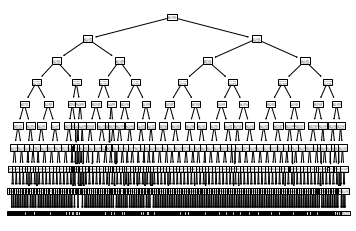

In [14]:
full_DTAnalyzer(X, X_test, y, y_test)

In [15]:
from sklearn.ensemble import AdaBoostRegressor
def full_DTAdaAnalyzer(X, X_test, y, y_test):
    start = timer()

    param_grid = [
        # try 4 (4) combinations of hyperparameters
        {'n_estimators': [100, 200, 300, 400]},
        ]

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=3, 
                                                     min_samples_split=2, min_samples_leaf=1, 
                                                     min_weight_fraction_leaf=0.0, max_features=None, 
                                                     random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                                     min_impurity_split=None, presort='deprecated', ccp_alpha=0.0), 
                                random_state=rng)

    # train across 5 folds, that's a total of 4*5=20 rounds of training 
    grid_search = GridSearchCV(ada_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(X, y)
    end = timer()
    grid_best_est=grid_search.best_estimator_
    print('Best estimator: '+str(grid_best_est))
    print('Best params: %s'%grid_search.best_params_)
    print('---------------------------------------------------------------------')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

    print('---------------------------------------------------------------------')
    results_display(grid_best_est, X, X_test, y, y_test)
    print('Full time consumption [s]: ', round((end - start),3))
    print('---------------------------------------------------------------------')

In [16]:
full_DTAdaAnalyzer(X, X_test, y, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best estimator: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
  

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  